##Implementation of Multiple Linear Regression using MPI and OpenMP

## Learning Objectives

At the end of the mini-project, we will be able to :

* understand the collective communication operations like scatter, gather, broadcast 
* understand the blocking and non-blocking communication
* implement multiple linear regression and run it using MPI
* implement the multiple linear regression based predictions using OpenMP

### Dataset

The dataset chosen for this mini-project is [Combined Cycle Power Plant](https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant). The dataset is made up of 9568 records and 5 columns. Each record contains the values for Ambient Temperature, Exhaust Vaccum, Ambient Pressure, Relative Humidity and Energy Output. 

Predicting full load electrical power output of a base load power plant is important in order to maximize the profit from the available megawatt hours.  The base load operation of a power plant is influenced by four main parameters, which are used as input variables in the dataset, such as ambient temperature, atmospheric pressure, relative humidity, and exhaust steam pressure. These parameters affect electrical power output, which is considered as the target variable.

**Note:** The data was collected over a six year period (2006-11).

## Information

#### MPI in a Nutshell

MPI stands for "Message Passing Interface". It is a library of functions (in C / Python) or subroutines (in Fortran) that you insert into source code to perform data communication between processes. MPI was developed over two years of discussions led by the MPI Forum, a group of roughly sixty people representing some forty organizations.


#### Multiple Linear Regression

Multiple regression is an extension of simple linear regression. It is used when we want to predict the value of a variable based on the value of two or more other variables. The variable we want to predict is called the dependent variable (or sometimes, the outcome, target or criterion variable). The variables we are using to predict the value of the dependent variable are called the independent variables (or sometimes, the predictor, explanatory or regressor variables).

**Note:** We will be using the mpi4py Python package for MPI based code implementation

## Grading = 20 Points

**Run the below code to install mpi4py package**

In [ ]:
!pip install mpi4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 39.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185316 sha256=6c17e0d31686c8aab248d074d1e0f9a8f74c51389f9d23aef5795824a6163439
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py


#### Importing Necessary Packages

In [ ]:
# Importing pandas
import pandas as pd 
# Importing Numpy
import numpy as np 
# Importing MPI from mpi4py package
from mpi4py import MPI 
# Importing sqrt function from the Math
from math import sqrt 
# Importing Decimal, ROUND_HALF_UP functions from the decimal package
from decimal import Decimal, ROUND_HALF_UP
import time 

In [ ]:
#@title Downloading the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/PowerPlantData.csv

### Overview

* Load the data and perform data pre-processing
* Identify the features, target and split the data into train and test
* Implement multiple Linear Regression by estimating the coefficients on the given data
* Use MPI package to distribute the data and implement `communicator`
* Define functions for each objective and make a script (.py) file to execute using MPI command
* Use OpenMP component to predict the data and calculate the error on the predicted data
* Implement the Linear Regression from `sklearn` and compare the results

#### Load data

Writing a function that takes the filename as input and loads the data in a pandas dataframe with the column names as Ambient Temperature, Exhaust Vaccum, Ambient Pressure, Relative Humidity and Energy Output respectively.



In [ ]:
FILENAME = "/content/PowerPlantData.csv" # Storing File path
# Defining a function to load the data
def loadData(filename): 
    # Loading the dataset with column names as 
    data = pd.read_csv(filename, header=0 , names = ['AmbientTemperature', 'ExhaustVaccum', 'AmbientPressure', 'RelativeHumidity', 'EnergyOutput'])
    # Returning the dataframe
    return data
# Calling the function loadData and storing the dataframe in a variable named df
df = loadData(FILENAME)

#### Explore data 

Writing a function that takes the data loaded using the above defined function as input and explore it.



- checking for the number of rows and columns
- summary of the dataset
- check for the null values 
- check for the duplicate values

In [ ]:
# Defining a function
def exploreData(data):
    print(data.shape) # Checking for number of rows and columns
    print(data.describe()) # Summary of the data
    print(data.isna()) # Checking for the null values in the data
    print(sum(data.duplicated()))  # Checking for the duplicate values in the data

In [ ]:
# Calling the function exploreData to understand the dataset
exploreData(df)

(9568, 5)
       AmbientTemperature  ExhaustVaccum  AmbientPressure  RelativeHumidity  \
count         9568.000000    9568.000000      9568.000000       9568.000000   
mean            19.651231      54.305804      1013.259078         73.308978   
std              7.452473      12.707893         5.938784         14.600269   
min              1.810000      25.360000       992.890000         25.560000   
25%             13.510000      41.740000      1009.100000         63.327500   
50%             20.345000      52.080000      1012.940000         74.975000   
75%             25.720000      66.540000      1017.260000         84.830000   
max             37.110000      81.560000      1033.300000        100.160000   

       EnergyOutput  
count   9568.000000  
mean     454.365009  
std       17.066995  
min      420.260000  
25%      439.750000  
50%      451.550000  
75%      468.430000  
max      495.760000  
      AmbientTemperature  ExhaustVaccum  AmbientPressure  RelativeHumidity  \
0 

#### Handle missing data

After exploring the dataset if there are any null values present in the dataset then define a function that takes data loaded using the above defined function as input and handle the null values accordingly.


In [ ]:
# Function to handle missing data
def handleMissingData(data): 
    data = data.dropna() # dropping the records containing null values using dropna function
    # returning the dataframe after dropping the values
    return data

In [ ]:
newdf = handleMissingData(df) # storing the data after removing the null values from it

#### Scaling the data 

Write a function that takes the data after handling the missing data as input and returns the standardized data.

$ (x - mean(x)) / std(x) $ 

In [ ]:
# Defining a function to standardize the data
def standardizeData(dataFile):
    # Applying standardization formula
    dataFile = (dataFile - dataFile.mean()) / dataFile.std()
    # returning the standardization data
    return dataFile

In [ ]:
ScaledData = standardizeData(newdf) # Storing the data after applying standardization on the data

####  Feature selection 

Writing a function that takes scaled data as input and returns the features and target variable value

- Features: AmbientTemperature, ExhaustVaccum, AmbientPressure, RelativeHumidity 
- Target Variable: EnergyOutput

In [ ]:
# Function which returns features and target variables
def FeatureSelector(data, target_name):
    target = data[target_name] # Storing the target values
    features = data.drop([target_name],axis=1) # Storing the features by dropping the target variable column
    return features, target # Returning the features and target 

In [ ]:
features, target = FeatureSelector(ScaledData,'EnergyOutput') # Storing the features and targets in variables respectively

#### Correlation

Calculating the correlation between the variables

[[ 1.          0.84410673 -0.50754934 -0.54253465]
 [ 0.          1.         -0.41350216 -0.31218728]
 [ 0.          0.          1.          0.09957432]
 [ 0.          0.          0.          1.        ]]


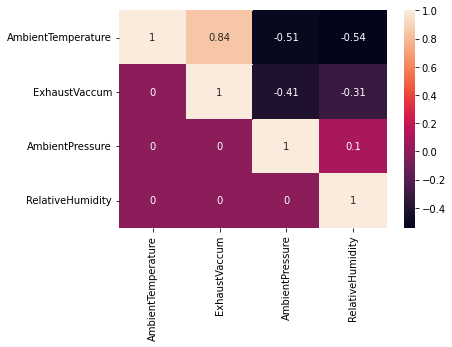

In [ ]:
def correlation_factor(features):
    corr = features.corr()
    print(np.triu(corr))
    return np.triu(corr)

import seaborn as sns
sns.heatmap(correlation_factor(features),annot=True,xticklabels=features.columns, yticklabels=features.columns)
# heatmap is optional

#### Estimating the coefficients 

Writing a function that takes features and target as input and returns the estimated coefficient values


In [ ]:
# Calculating the coefficients
def estimatedCoefficients(x, y):
    # Implementing above formula
    xT = x.transpose() # Transpose of x
    inversed = np.linalg.inv( xT.dot(x) ) # Inverse of a matrix
    coefficients = inversed.dot( xT ).dot(y) # performing final dot operation
    # Returning the coefficients
    return coefficients

In [ ]:
estimatedCoefficients(features, target) # Calculating the estimatedCoefficients

array([-0.86350078, -0.17417154,  0.02160293, -0.13521023])

#### Fit the data to estimate the coefficients

Write a function named fit which takes features and targets as input and returns the intercept and coefficient values.


- creating a dummy column in the features dataframe which is made up of all ones
- converting the features dataframe into numpy array
- calling the estimated coefficients function which is defined above

In [ ]:
# function to add dummy column into features dataframe and converting it into numpy array
def dummyvariable(features):
    # create a array of ones
    m = np.ones((features.shape[0],1))
    # combining the array of ones with features array
    f = np.concatenate((m,features),axis=1) 
    # returning the features array
    return f

In [ ]:
# defining a fit function
def fit(x, y):
    # prepare x and y values for coefficient estimates
    x = dummyvariable(x) # adding a dummy column
    print(x)
    #y = y.values
    betas = estimatedCoefficients(x, y) # calculating the estimated coefficients
    # intercept becomes a vector of ones
    intercept = betas[0]
    # coefficients becomes the rest of the betas
    coefficients = betas[1:]
    # returning the intercept and coefficients
    return intercept, coefficients

In [ ]:
intercept, coefficients = fit(features, target) # fitting the data and calculating the intercept and coefficients

[[ 1.         -1.5177822  -1.06514933 -0.40733563  1.14388457]
 [ 1.          0.53522753  0.32925964 -0.31304022  0.06102779]
 [ 1.          1.35374774  0.20414055 -1.02867497 -2.15057533]
 ...
 [ 1.         -0.49127733 -0.86291282  0.15843679  0.36650162]
 [ 1.         -0.26853249  0.43785357  0.89596154  1.46168694]
 [ 1.          0.54059487 -0.23653046 -0.23558329 -0.1417082 ]]


####Predict the data on estimated coefficients

Writing a function named predict which takes features, intercept and coefficient values as input and returns the predicted values.


In [ ]:
# fucntion to predict the values
def predict(x, intercept, coefficients):
    '''
    y = b_0 + b_1*x + ... + b_i*x_i
    '''
    predictions = [] # Defining empty list to store the predicted values 
    for index, row in x.iterrows(): # iterating over features
        values = row.values # converting each row into a array
        pred = np.multiply(values, coefficients) # multiply the coefficients with the features values
        pred = sum(pred) # storing the sum of each features
        pred += intercept # finally adding the intercept value
        predictions.append(pred) # appending the values to the list
    # returning the predictions
    return predictions

In [ ]:
predict(features, intercept, coefficients ) # Calling the predict function

[1.33266026849625,
 -0.5345312156768379,
 -0.9359603112233165,
 0.07640425272942485,
 0.8895610687748626,
 0.7714443944520082,
 -0.5540970083885266,
 0.7567708975439705,
 -1.225428897304558,
 1.6576241437761479,
 -1.1901941130364428,
 -0.06129230454304908,
 -1.230168290299314,
 1.4838856543859595,
 0.5991596163999573,
 -0.3417226488979428,
 0.5635378395088394,
 0.98645915762327,
 1.3799471435419066,
 0.016165506010770346,
 0.5509266925803932,
 -1.5941946090140535,
 -0.8408643749820662,
 1.5063037370200536,
 0.8948976502458754,
 1.8016617438510365,
 -0.9186668554398925,
 1.391217520691064,
 -0.23382065669812335,
 -0.8177208734031922,
 0.6235815159730964,
 -0.2632052849894913,
 1.5159680947234382,
 -1.227342437435256,
 -1.4377625642757745,
 0.6428679501226953,
 -0.7731004649629727,
 -0.9002495713576678,
 1.4934873187019377,
 -0.5178002934355969,
 -1.2498121464812122,
 -0.5052113845219294,
 0.6706893189169826,
 -0.7472770960987112,
 0.1386320380111921,
 -0.9615082705451099,
 0.44417252909

#### Root mean squared error

Writing a function to calculate the RMSE error. 


In [ ]:
# function to calculate the error
def rmse(actual, predicted):
        # To store the value
        sum_err = 0.0
        # iterating over the actual values
        for i in range(len(actual)):
            # calculating mean squared error
            pred_err = predicted[i] - actual[i]
            sum_err += pred_err ** 2
        mean_err = sum_err / float(len(actual))
        # squaring the mean squared error to get the RMSE error value
        return sqrt(mean_err)

#### Splitting the data into train and test

Writing a function named train_test_split which takes features and targets as input and returns the train and test sets respectively.


In [ ]:
# Divide the data into 70% train set and 30% test set 
def train_test_split(features_X , expected_target_Y ):    
    #Randomly pick 70% 0f the data 
    set_of_data = np.random.rand(len(features_X)) <= 0.7
    X_train = features_X[set_of_data] # Training features set
    Y_train = expected_target_Y[set_of_data] # target train set
    #the remaining 30% is for the test set
    X_test  = features_X[~set_of_data] # Test features set
    Y_test  = expected_target_Y[~set_of_data] # target test sets
    # Returning the train features set, train targets set, test features sets, test target sets
    return X_train, X_test, Y_train, Y_test 

#### Create a communicator 

Creating a comunicator and define the rank and size

In [ ]:
# Initialize communicator
comm = MPI.COMM_WORLD  
# ID of the current worker 
rank = comm.Get_rank()  
# Rank ID of sender
status = MPI.Status()    
# Number of workers 
size = comm.Get_size()                      
root = 0   # Root
# to calculate time
t_start = 0
t_diff = 0

#### Dividing the data into slices 

Writing a function named dividing_data which takes train features set, train target set, and size of workers as inputs and returns the sliced data for each worker.

![img](https://cdn.iisc.talentsprint.com/CDS/Images/MiniProject_MPI_DataSlice.JPG)

For Example, if there are 4 processes, slice the data into 4 equal parts with 25% ratio



In [ ]:
def dividing_data(x_train, y_train, size_of_workers):
    #Divide the data among the workers
    slice_for_each_worker = int(Decimal(x_train.shape[0]/size_of_workers).quantize(Decimal('1.'), rounding = ROUND_HALF_UP))      
    print('Slice of data for each worker: {}'.format(slice_for_each_worker))
    x_data_for_worker = []
    y_data_for_worker = []
    for i in range(0,size_of_workers):
        if i < size_of_workers - 1:
            x_data_for_worker.append(x_train[slice_for_each_worker*i:slice_for_each_worker*(i+1)])
            y_data_for_worker.append(y_train[slice_for_each_worker*i:slice_for_each_worker*(i+1)])
        else:
            x_data_for_worker.append(x_train[slice_for_each_worker*i:])
            y_data_for_worker.append(y_train[slice_for_each_worker*i:])
    return x_data_for_worker, y_data_for_worker

# Alternate way is to use np.split()

#### Prepare the data in root worker to assign data for all the workers 

- When it is the root worker, we have to perform the below operations:
    - Storing the features and target values in separate variables
    - Splitting the data into train and test sets using the train_test_split function defined above
    - Dividing the data among the workers using the dividing_data function above

In [ ]:
if rank == root:
    t_start = MPI.Wtime()
    # Splitting the data into train and test
    X_train, X_test, Y_train, Y_test =  train_test_split(features, target)
    #Divide the data among the workers 
    x_data_for_worker, y_data_for_worker = dividing_data(X_train, Y_train, size)
wt = MPI.Wtime()

Slice of data for each worker: 6760


#### Scatter and gather the data

Performing the below operations:

- Send slices of the training set(the features data X and the expected target data Y) to every worker including the root worker. Workers in the group reach a Barrier, to scatter from root worker.
- Every worker should get the predicted target Y(yhat) for each slice
- we have to get the new coefficient of each instance in a slice

- Then Calculate the root mean square error for the test set



In [ ]:
# Send the slice of data to work on to each worker    
sliced_features_X_train = comm.scatter(x_data_for_worker, root = root)
sliced_expected_target_Y_train = comm.scatter(y_data_for_worker, root = root)
Xm = sliced_features_X_train.values
ym = sliced_expected_target_Y_train.values

In [ ]:
# checking the shape of features and target received scatter
Xm.shape, ym.shape

((6760, 4), (6760,))

In [ ]:
# fit the data with x, y to calculate the coefficients
b0, new_coefficients = fit(Xm, ym)

[[ 1.         -1.5177822  -1.06514933 -0.40733563  1.14388457]
 [ 1.          0.53522753  0.32925964 -0.31304022  0.06102779]
 [ 1.          1.35374774  0.20414055 -1.02867497 -2.15057533]
 ...
 [ 1.          1.84620171  1.86059139 -0.49826334 -0.93073477]
 [ 1.         -0.26853249  0.43785357  0.89596154  1.46168694]
 [ 1.          0.54059487 -0.23653046 -0.23558329 -0.1417082 ]]


In [ ]:
b0, new_coefficients 

(-0.00020304547654217747,
 array([-0.86711523, -0.17264495,  0.01982016, -0.13700176]))

#### Predict the output using the new coefficients

In [ ]:
predicted_y_sliced = predict(sliced_features_X_train, b0, new_coefficients)

#### Gather the new coefficients and calculate the error on train and test data

In [ ]:
# Gather the new coeffiecient for each slice of the training data
gather_new_coefficients = pd.DataFrame(comm.gather(new_coefficients, root=0))
comm.barrier()
if rank == root:
    coef = gather_new_coefficients.mean()
    #print(coef)
    predicted_y = predict(X_test, intercept, coef)    
    print("Test set error(RMSE) is {}" .format(rmse(Y_test.values, np.array(predicted_y))))
    #print("Train set error(RMSE) is {}" .format( rmse(Y_train.values, np.array(predicted_y_sliced))))
t_diff = MPI.Wtime() - t_start   
print('Process {}: {} secs.' .format(rank,t_diff))

Test set error(RMSE) is 0.2582422204299728
Process 0: 0.8492911789999766 secs.


#### Making a script and execute everything in one place 

Writing a script(.py) file which contains the code of all the above exercises in it so that you can run the code on multiple processes using MPI.


In [ ]:
%%writefile mlrMPI.py

import pandas as pd # Importing pandas package under a name pd
import numpy as np # Importing Numpy package under a name np
from mpi4py import MPI # Importing MPI fro mpi4py package
from math import sqrt # Importing sqrt function from the Math package
from decimal import Decimal, ROUND_HALF_UP # Importing Decimal, ROUND_HALF_UP functions from the decimal package

FILENAME = "/content/PowerPlantData.csv" # Storing File path
# Defining a function to load the data
def loadData(filename): 
    # Loading the dataset with column names as 
    data = pd.read_csv(filename, header=0 , names = ['AmbientTemperature', 'ExhaustVaccum', 'AmbientPressure', 'RelativeHumidity', 'EnergyOutput'])
    # Returning the dataframe
    return data
# Calling the function loadData and storing the dataframe in a variable named df
df = loadData(FILENAME)

 # Defining a function
def exploreData(data):
    print(data.shape) # Checking for number of rows and columns
    print(data.describe()) # Summary of the data
    print(data.isna()) # Checking for the null values in the data
    print(sum(data.duplicated()))  # Checking for the duplicate values in the data
 # Function to handle missing data
def handleMissingData(data): 
    data = data.dropna() # dropping the records containing null values using dropna function
    # returning the dataframe after dropping the values
    return data

newdf = handleMissingData(df) # storing the data after removing the null values from it

 # Defining a function to standardization the data
def standardizeData(dataFile):
    # Applying standardize formula
    dataFile = (dataFile - dataFile.mean()) / dataFile.std()
    # returning the standardization data
    return dataFile

ScaledData = standardizeData(newdf) # Storing the data after applying normalization on the data

# Function which returns features and target variables
def FeatureSelector(data,target_name):
    target = data[target_name] # Storing the target values
    features = data.drop([target_name],axis=1) # Storing the features by dropping the target variable column
    return features, target # Returning the features and target   

features, target = FeatureSelector(ScaledData,'EnergyOutput') # Storing the features and targets in variables respectively

 # Calculating the coefficients
def estimatedCoefficients(x, y):
    # Implementing above formula
    xT = x.transpose() # Transpose of x
    inversed = np.linalg.inv( xT.dot(x) ) # Inverse of a matrix
    coefficients = inversed.dot( xT ).dot(y) # performing final dot operation
    # Returning the coefficients
    return coefficients

 # function to add dummy column into features dataframe and converting it into numpy array
def dummyvariable(features):
    # create a array of ones
    m = np.ones((features.shape[0],1))
    # combining the array of ones with features array
    f = np.concatenate((m,features),axis=1) 
    # returning the features array
    return f

 # defining a fit function
def fit(x, y):
    # prepare x and y values for coefficient estimates
    x = dummyvariable(x) # adding a dummy column
    # y = y.values
    betas = estimatedCoefficients(x, y) # calculating the estimated coefficients
    # intercept becomes a vector of ones
    intercept = betas[0]
    # coefficients becomes the rest of the betas
    coefficients = betas[1:]
    # returning the intercept and coefficients
    return intercept, coefficients

intercept, coefficients = fit(features, target) # fitting the data and calculating the intercept and coefficients

  # function to predict the values
def predict(x, intercept, coefficients):
    '''
    y = b_0 + b_1*x + ... + b_i*x_i
    '''
    predictions = [] # Defining empty list to store the predicted values 
    for index, row in x.iterrows(): # iterating over features
        values = row.values # converting eaach row into a array
        pred = np.multiply(values, coefficients) # multiply the coefficients with the features values
        pred = sum(pred) # storing the sum of each features
        pred += intercept # finally adding the intercept value
        predictions.append(pred) # appending the values to the list
    # returning the predictions
    return predictions

 # function to calculate the error
def rmse(actual, predicted):
        # To store the value
        sum_err = 0.0
        # iterating over the actual values
        for i in range(len(actual)):
            # calculating mean squared error
            pred_err = predicted[i] - actual[i]
            sum_err += pred_err ** 2
        mean_err = sum_err / float(len(actual))
        # squaring the mean squared error to get the RMSE error value
        return sqrt(mean_err)

 # Divide the data into 70% train set and 30% test set 
def train_test_split(features_X , expected_target_Y ):    
    #Randomly pick 70% 0f the data 
    set_of_data = np.random.rand(len(features_X)) <= 0.7
    X_train = features_X[set_of_data] # Training features set
    Y_train = expected_target_Y[set_of_data] # target train set
    #the remaining 30% is for the test set
    X_test  = features_X[~set_of_data] # Test features set
    Y_test  = expected_target_Y[~set_of_data] # target test sets
    # Returning the train features set, train targets set, test features sets, test target sets
    return X_train, X_test, Y_train, Y_test 

def dividing_data(x_train, y_train, size_of_workers):
    #Divide the data among the workers
    slice_for_each_worker = int(Decimal(x_train.shape[0]/size_of_workers).quantize(Decimal('1.'), rounding = ROUND_HALF_UP))      
    print('Slice of data for each worker: {}'.format(slice_for_each_worker))
    x_data_for_worker = []
    y_data_for_worker = []
    for i in range(0,size_of_workers):
        if i < size_of_workers - 1:
            x_data_for_worker.append(x_train[slice_for_each_worker*i:slice_for_each_worker*(i+1)])
            y_data_for_worker.append(y_train[slice_for_each_worker*i:slice_for_each_worker*(i+1)])
        else:
            x_data_for_worker.append(x_train[slice_for_each_worker*i:])
            y_data_for_worker.append(y_train[slice_for_each_worker*i:])
    return x_data_for_worker, y_data_for_worker

def main():
    comm = MPI.COMM_WORLD                       # Initialize communicator
    rank = comm.Get_rank()                        # ID of the cureent worker 
    status = MPI.Status()                       # Rank ID of sender
    size = comm.Get_size()                      # Number odf workers 
    root = 0   # Root  
    x_data_for_worker, y_data_for_worker = [], []
    if rank == root:
        # Splitting the data into train and test
        X_train, X_test, Y_train, Y_test =  train_test_split(features, target)
        #Divide the data among the workers 
        x_data_for_worker, y_data_for_worker = dividing_data(X_train, Y_train, size)
    
    # Send the slice of data to work on to each worker    
    sliced_features_X_train = comm.scatter(x_data_for_worker, root = root)
    sliced_expected_target_Y_train = comm.scatter(y_data_for_worker, root = root)
    Xm = sliced_features_X_train.values
    ym = sliced_expected_target_Y_train.values
    # fit the data with x, y to calculate the coefficients
    b0, new_coefficients = fit(Xm, ym)
    ##predicted_y_sliced = predict(sliced_features_X_train, b0, new_coefficients)
    # Gather the new coeffiecient for each slice of the training data
    gather_new_coefficients = pd.DataFrame(comm.gather(new_coefficients, root=0))
    comm.barrier()
    if rank == root:
        coef = gather_new_coefficients.mean()
        #print(coef)
        predicted_y = predict(X_test, intercept, coef)    
        print("Test set error(RMSE) is {}" .format(rmse(Y_test.values, np.array(predicted_y))))

main()

Writing mlrMPI.py


In [ ]:
!mpirun --allow-run-as-root -np 4 python mlrMPI.py

Slice of data for each worker: 1665
Test set error(RMSE) is 0.26344130934227306


#### Implementing and predicting using OpenMP 

Get the predictions for test data and calculate the test error(RMSE) by implementing the OpenMP (pymp)

In [ ]:
!pip install pymp-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pymp-pypi: filename=pymp_pypi-0.5.0-py3-none-any.whl size=10339 sha256=4ab326d563761b1a38e52e39ef3e571eb415aa789eba3f45f4ba779a579c353d
  Stored in directory: /root/.cache/pip/wheels/22/2a/4e/d49c406bb5eb2c04b424940de41d40b3b1481c31b9f93a13c1
Successfully built pymp-pypi


In [ ]:
import pymp
def predict(x, intercept, coefficients):
    '''
    y = b_0 + b_1*x + ... + b_i*x_i
    '''
    st = time.perf_counter()
    predictions = pymp.shared.array(Y_test.shape) # Defining empty list to store the predicted values 
    with pymp.Parallel(4) as p:
      for index in p.range(len(x)): # iterating over features
          values = x[index] # converting eaach row into a array
          pred = np.multiply(values, coefficients) # multiply the coefficients with the features values
          pred = sum(pred) # storing the sum of each features
          pred += intercept # finally adding the intercept value
          predictions[index]= pred # appending the values to the list
    # returning the predictions
    print(time.perf_counter() - st)
    
    return predictions

In [ ]:
# predicting the test data
test_predictions = np.array(predict(X_test.values, b0, new_coefficients))

# calculating the error
print("Test set error(RMSE) is {}" .format(rmse(Y_test.values, test_predictions)))

0.13173130200001992
Test set error(RMSE) is 0.2582426845869598


#### Using Sklearn to compare 

Apply the Linear regression on the given data using sklearn package and compare with the above results



In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(features, target)

In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(xtrain, ytrain)
predictions = reg.predict(xtest)

In [ ]:
# coefficients from sklearn Linear Regression
print(reg.coef_)
# intercept from sklearn Linear Regression
print(reg.intercept_)

[-0.86916784 -0.1745251   0.01606232 -0.13849774]
0.0007889227277654812


In [ ]:
from sklearn.metrics import mean_squared_error
print(sqrt(mean_squared_error(predictions, ytest)))

0.2738613264685041
